/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_27790/3201865000.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target,RSI
2893,355.666656,357.660004,332.519989,335.600006,92713200,2.524839,56.185597
2894,364.646667,372.333344,356.906677,357.890015,71145900,-0.500028,58.566846
2895,362.823334,373.000000,359.473328,369.829987,60324000,-0.209471,54.005058
2896,362.063324,368.000000,354.713318,366.213318,56154000,-1.459227,51.942541
2897,356.779999,365.183319,351.049988,353.776672,47040900,-1.266884,58.440305
...,...,...,...,...,...,...,...
3874,395.230011,428.940002,394.739990,414.630005,113548800,-1.047495,32.101801
3875,391.089996,402.799988,383.760010,402.320007,100460600,6.824517,26.390087
3876,417.779999,421.720001,401.089996,402.170013,96806400,0.387763,42.035612
3877,419.399994,420.480011,405.950012,414.420013,71915600,1.711968,35.781409


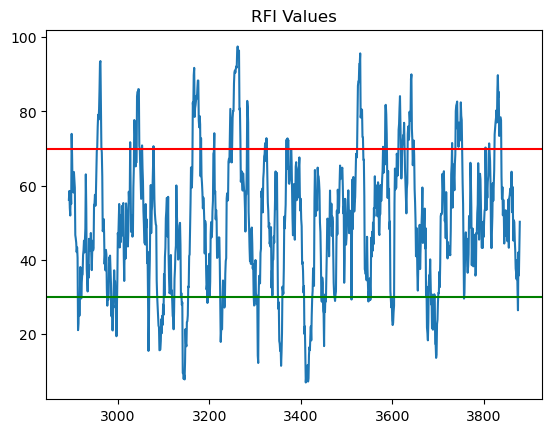

In [1]:
## We will change our Regresison Analysis to be able to Validate Regression Outpu all in one function

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# --- GLOBAL PARAMETERS ---

# Step 1: Ticker
TICKER = "TSLA"


# Step 2: Price Behavior
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Step 3: Strategy/Independet Variable (FGV)
STRATEGY = "RSI"

RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 4: shift days back for the calculation
SHIFT = 1

# Step 5: Data Subsction (How many rows will we analyze)
LOOKBACK = 1000

# --- (1) Download Data into df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots (Index instead Datum)
    df = df.reset_index(drop=True)

    # Step 4: Return only LOOKBACK Rows
    return df.iloc[-lookback:, :]

# --- (2) Defining Dependent/Target Variable ---

def add_target(df, shift = SHIFT):

    # Step 1: Define Delta/Price Change (Tomorrow - Today), in percentage Terms * 100
    df["Target"] = (df["Close"].shift(-shift) - df["Close"])/df["Close"] * 100

    # Step 2: Return df 
    return df

# --- (3) Defining Independent/Feature Variable ---

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta/Price Change (Today - Yesterday)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Ngeative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate teh Relative Strength 
    rs = avg_gain / avg_loss

    # Step 5: Calculate the RSI w/ Standardization (Values between -100)
    df["RSI"] = 100 - (100/(1+rs))

     # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red") # Crossing Overbrought Line: triggers Short Signal
    plt.axhline(oversold, color="green") # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()
    


def main():

    df = get_data()
    df = add_target(df)
    df = add_RSI(df)

    return df

df = main()
df
